# **Wiktor Ciołek LSED lab3 28.03.2024**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 18


from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.inspection import DecisionBoundaryDisplay as dbd

from sklearn import metrics

# Data imported

In [2]:
data = pd.read_csv('wines.data', delimiter=',', header=None)
data.columns = ['class', 'alcohol', 'acid', "ash", 'alcanity', 'magnesium', 'tot_phen', 'flav', 'nonflav_phen', 'proanth', 'color', 'hue', 'OD', 'proline']
data.sample(6)

,class,alcohol,acid,ash,alcanity,magnesium,tot_phen,flav,nonflav_phen,proanth,color,hue,OD,proline
94,2,11.62,1.99,2.28,18.0,98,3.02,2.26,0.17,1.35,3.25,1.16,2.96,345
46,1,14.38,3.59,2.28,16.0,102,3.25,3.17,0.27,2.19,4.90,1.04,3.44,1065
41,1,13.41,3.84,2.12,18.8,90,2.45,2.68,0.27,1.48,4.28,0.91,3.00,1035
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045
168,3,13.58,2.58,2.69,24.5,105,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750
24,1,13.50,1.81,2.61,20.0,96,2.53,2.61,0.28,1.66,3.52,1.12,3.82,845


Index(['class', 'alcohol', 'acid', 'ash', 'alcanity', 'magnesium', 'tot_phen',
       'flav', 'nonflav_phen', 'proanth', 'color', 'hue', 'OD', 'proline'],
      dtype='object')


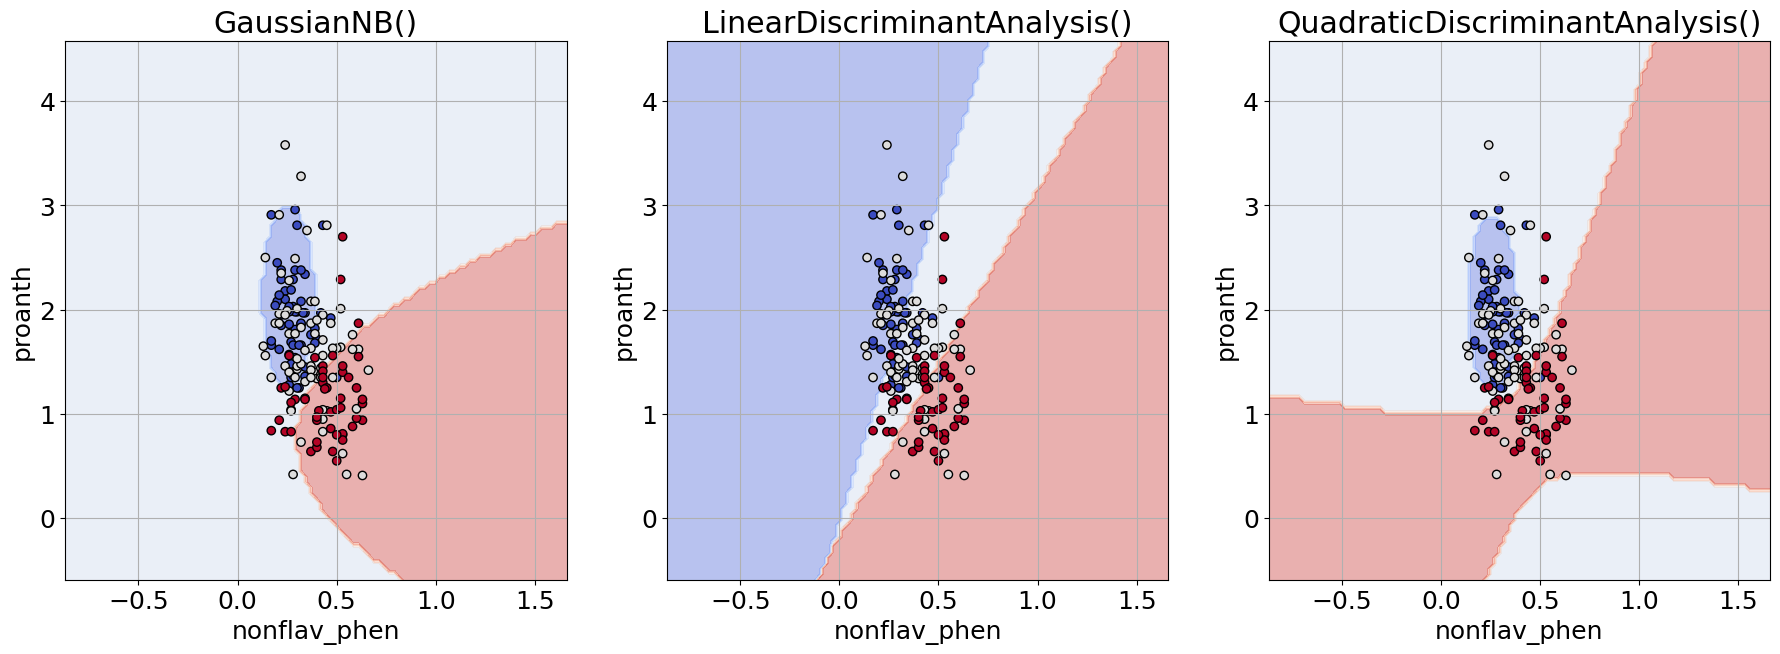

In [3]:
nb = GaussianNB()
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
clfs = [nb, lda, qda]
print(data.columns)

col1, col2 = 8, 9

fig, ax = plt.subplots(1, 3, figsize=(22, 7))
for i, clf in enumerate(clfs):
    clf.fit(data.iloc[:, [col1,col2]], data['class'])
    dbd.from_estimator(clf, X=data.iloc[:, [col1, col2]], cmap=plt.cm.coolwarm, alpha=0.4, ax=ax[i])
    ax[i].scatter(data=data, x=data.columns[col1], y=data.columns[col2], c='class', cmap=plt.cm.coolwarm, edgecolor='black')
    ax[i].set_title(clf)


# Number of features impact

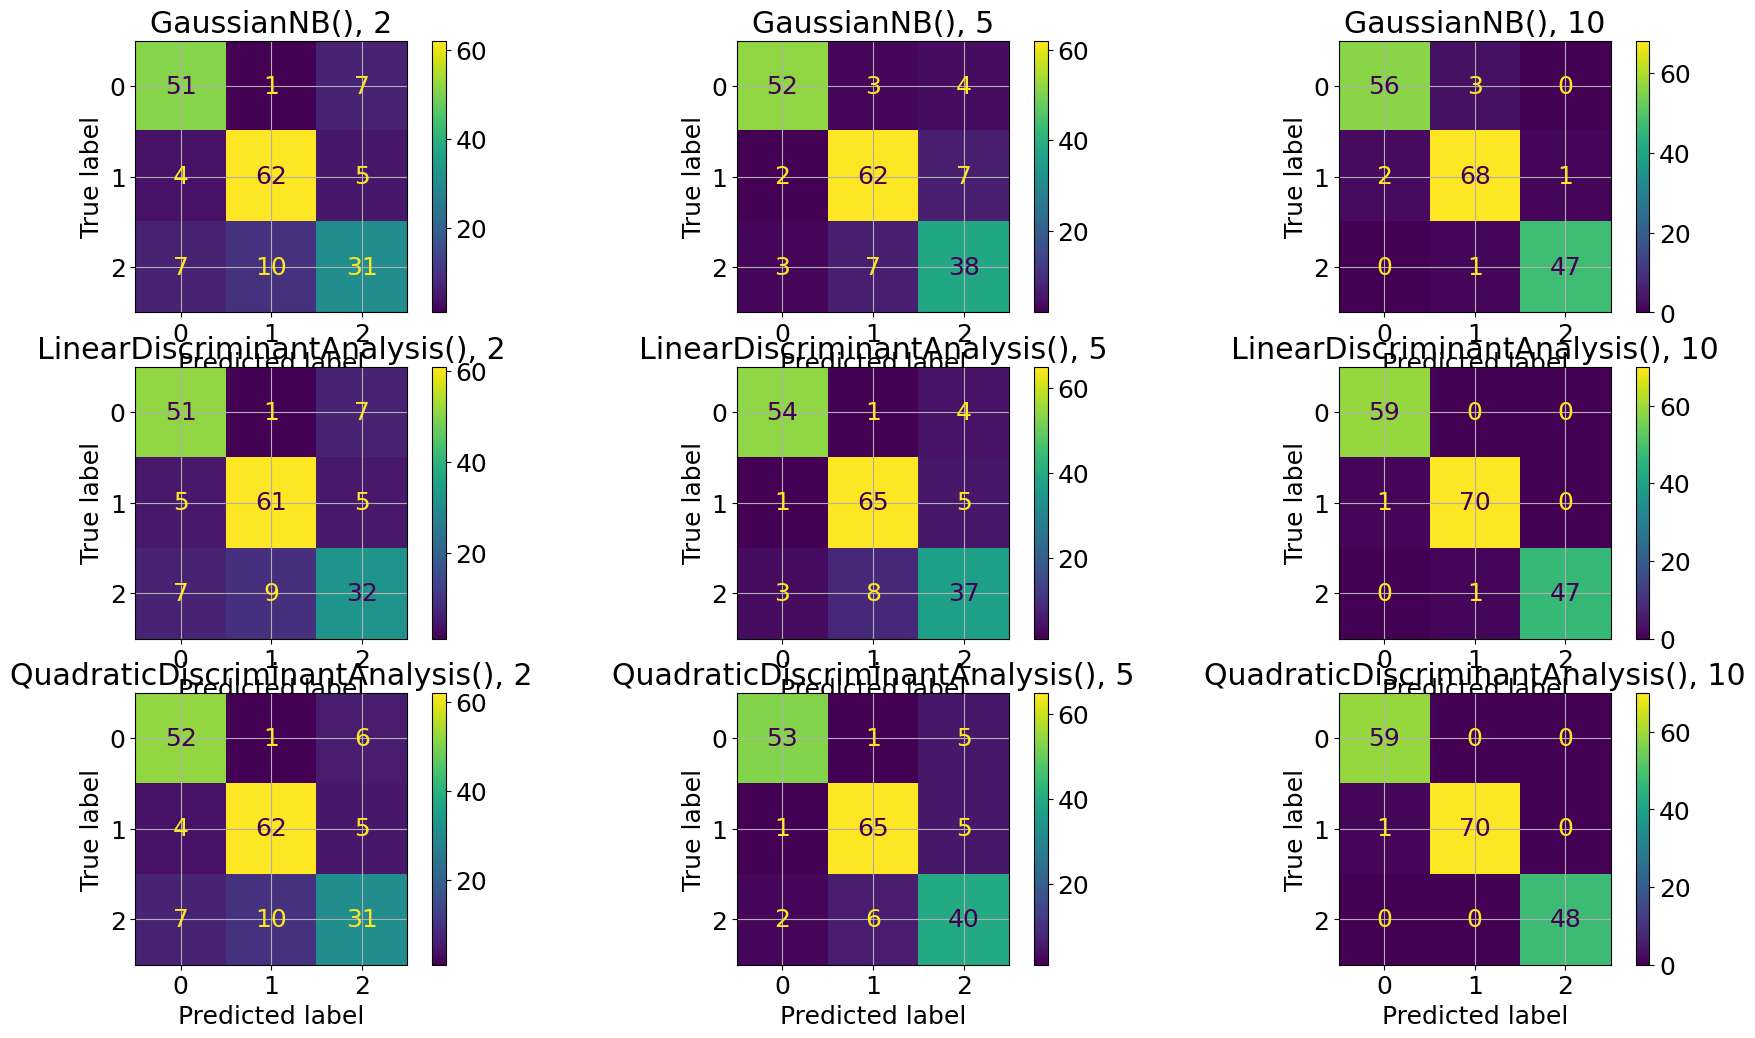

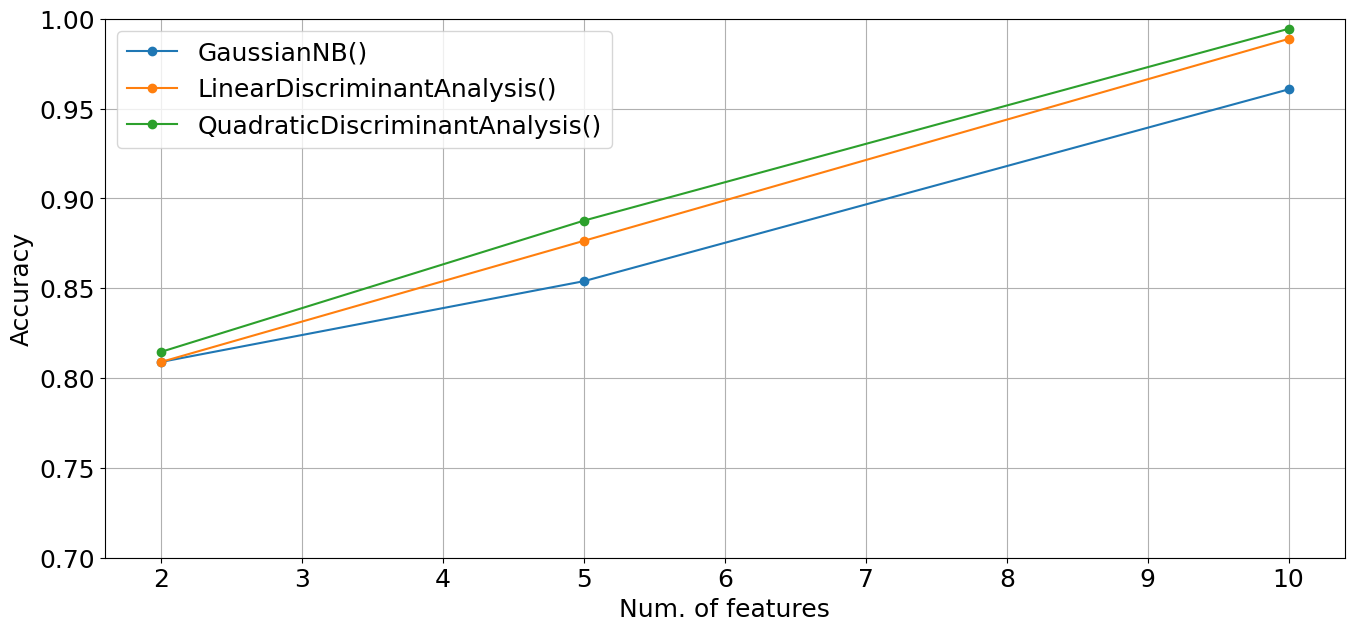

In [4]:
show_cm, show_acc = True, True

num_features = [2, 5, 10]
if show_cm:
    fig1, ax1 = plt.subplots(len(clfs), len(num_features), figsize=(22, 12))
if show_acc:
    fig2, ax2 = plt.subplots(1, 1, figsize=(16, 7))
    acc = np.zeros((len(clfs), len(num_features)))
for i, num in enumerate(num_features):
    for j, clf in enumerate(clfs):
        clf.fit(data.iloc[:, 1:num_features[i]+1], data['class'])
        y_pred = clf.predict(data.iloc[:, 1:num_features[i]+1])
        if show_cm:
            cm = metrics.confusion_matrix(data['class'], y_pred)
            metrics.ConfusionMatrixDisplay(cm).plot(ax=ax1[j, i])
            ax1[j, i].set_title(f'{clf}, {num}')
        if show_acc:
            acc[j, i] = metrics.accuracy_score(data['class'], y_pred)
            
            ax2.set_xlabel('Num. of features')
            ax2.set_ylabel('Accuracy')
            ax2.set_ylim(0.7,1)
            

if show_acc:
    for j in range(len(clfs)):
        ax2.plot(num_features, acc[j], 'o-', label=clfs[j])
    ax2.legend()


# Validation set model comparison 

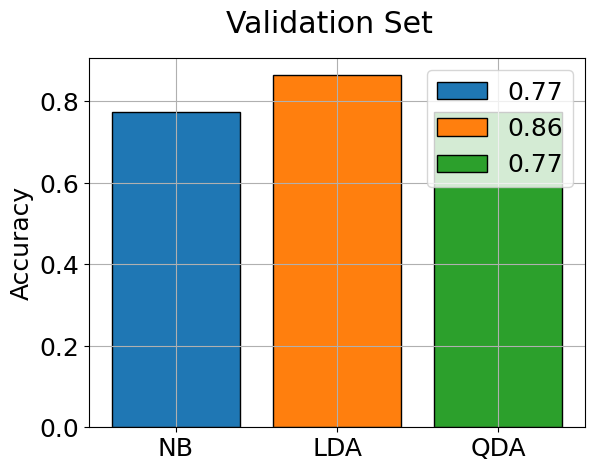

In [5]:
shuffled_df = data.sample(frac=1, random_state=42)

train_frac = 0.5
valid_frac = 0.25
test_frac = 0.25

total_rows = len(shuffled_df)
train_rows = int(train_frac * total_rows)
valid_rows = int(valid_frac * total_rows)
test_rows = total_rows - train_rows - valid_rows

train_set = shuffled_df.iloc[:train_rows]
valid_set = shuffled_df.iloc[train_rows:train_rows + valid_rows]
test_set = shuffled_df.iloc[train_rows + valid_rows:]

for i, clf in enumerate(clfs):
    clf.fit(train_set.iloc[:, [1,2]], train_set['class'])
    y_pred = clf.predict(valid_set.iloc[:, [1,2]])
    acc = metrics.accuracy_score(y_pred, valid_set['class'])
    plt.bar(i, acc, edgecolor='black', label=f'{acc:.2f}')
plt.xticks([0,1,2], ['NB', 'LDA', 'QDA'])
plt.ylabel('Accuracy')
plt.suptitle('Validation Set')
plt.legend()

# Cross-validation and Resubstitution - comparison with validation set technique

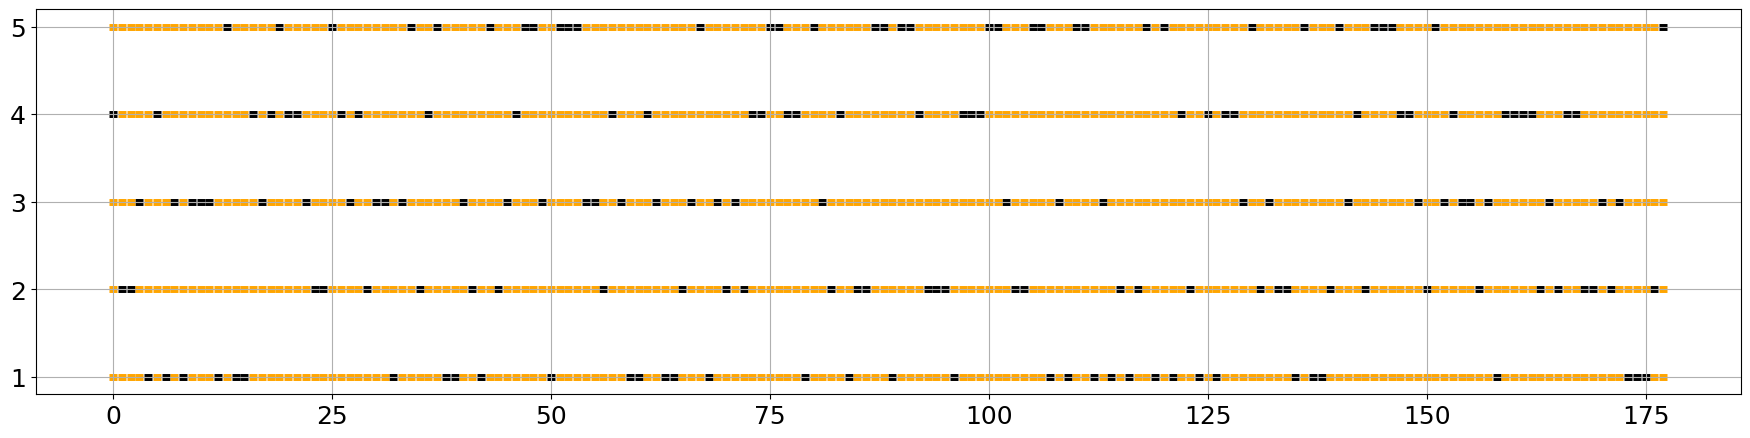

Estimated score: 0.78
Std error: 0.05


In [6]:
from sklearn.model_selection import KFold, cross_val_score

fig, ax = plt.subplots(figsize=(22,5))
kf = KFold(n_splits=5, shuffle=True)
for i, (train, test) in enumerate(kf.split(data.iloc[:, [1,2]])):
    ax.scatter(test, np.tile(i, len(test)), marker = "_", lw = 5, facecolor='black')
    ax.scatter(train, np.tile(i, len(train)), color = "orange", marker = "_", lw = 5)

ax.set(yticks=np.arange(5),yticklabels=np.arange(1,6))
plt.show()

cvs = cross_val_score(lda, data.iloc[:, [1,2]], data['class'], cv = kf)
cv_score = cvs.mean()
print(f"Estimated score: {cv_score:.2f}")
print(f"Std error: {cvs.std():.2f}")

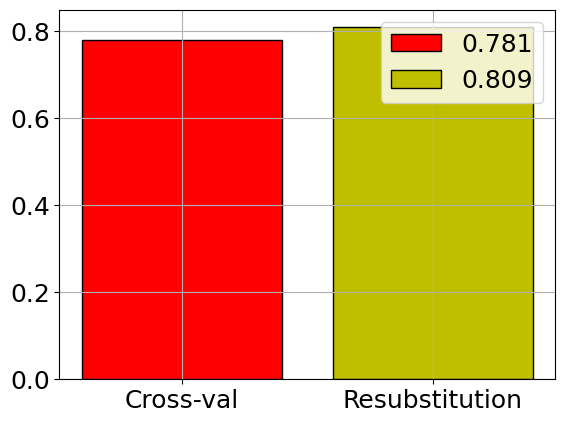

In [7]:
lda.fit(data.iloc[:, [1,2]], data['class'])
y_pred = lda.predict(data.iloc[:, [1,2]])
resub_score = metrics.accuracy_score(y_pred, data['class'])

plt.bar(['Cross-val', 'Resubstitution'], [cv_score, resub_score], color=['r','y'], edgecolor='k', label=[f'{cv_score:.3f}', f'{resub_score:.3f}'])
plt.legend()